In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import astropy.units as u

In [27]:
from vasca.utils import tgalex_to_astrotime
from astropy.io import fits
from astropy.wcs import WCS

In [17]:
from run_gfind import run_gFind, run_gMap, run_gAperture, plot_map, plot_lc, get_out_dir

# Transients & sky locations

In [6]:
# Load transient list
load_locs = True
if load_locs:
    # load cached CSV file
    df_locs = pd.read_csv("transients.csv", index_col=0)
    # convert location rows to float
    df_locs.iloc[0] = df_locs.iloc[0].apply(float)
    df_locs.iloc[1] = df_locs.iloc[1].apply(float)
df_locs

,PS1-10jh,PS1-11af,D3-13,D1-9,D23H-1,PS1-13arp,SN-2010aq,test
ra,242.368075,149.36175,214.8741,36.3207,352.998042,184.604295,150.540587,176.919526
dec,53.673492,3.23361,52.8684,4.5497,0.287381,46.616852,1.233594,0.255697
trans_type,TDE,TDE,TDE,TDE,TDE,SN2p,SN2p,test
pub_date,2012,2013,2006,2008,2009,2008,2010,0


# gFind

In [8]:
transient = "PS1-10jh"
config_gfind = {
    "transient": transient,
    "band": "NUV",
    "ra": df_locs[transient].ra,
    "dec": df_locs[transient].dec,
    "detsize": 1.2,
    "maxgap": 400,
    "refresh": True,
    "overwrite": True,
    "retries": 3,
    "quiet": False,
    "verbose": 3,
}

In [9]:
%%time
gfind_res = run_gFind(**config_gfind)

NUV: 68861.0s (raw) in 60 exposures.re.                     
    [ 768413479.995, 768413580.995 ], 101.000 seconds
    [ 772224465.995, 772225688.995 ], 1223.000 seconds
    [ 773123709.995, 773124202.995 ], 493.000 seconds
    [ 775283436.995, 775285077.995 ], 1641.000 seconds
    [ 799089890.995, 799091497.995 ], 1607.000 seconds
    [ 799225954.995, 799227043.995 ], 1089.000 seconds
    [ 799291027.995, 799292207.995 ], 1180.000 seconds
    [ 799296943.995, 799297509.995 ], 566.000 seconds
    [ 799308775.995, 799309669.995 ], 894.000 seconds
    [ 799415698.995, 799415804.995 ], 106.000 seconds
    [ 802267370.995, 802268489.995 ], 1119.000 seconds
    [ 802332505.995, 802333573.995 ], 1068.000 seconds
    [ 802374181.995, 802374993.995 ], 812.000 seconds
    [ 802450944.995, 802451924.995 ], 980.000 seconds
    [ 806060123.995, 806061578.995 ], 1455.000 seconds
    [ 806071957.995, 806073409.995 ], 1452.000 seconds
    [ 806083791.995, 806085240.995 ], 1449.000 seconds
    [ 80610

In [10]:
[[tgalex_to_astrotime(ts, "iso"), dt] for ts, dt in zip(gfind_res["NUV"]["t0"], gfind_res["NUV"]["dt"])]

[['2004-05-12 16:11:19.995', 101.0],
 ['2004-06-25 18:47:45.995', 1223.0],
 ['2004-07-06 04:35:09.995', 493.0],
 ['2004-07-31 04:30:36.995', 1641.0],
 ['2005-05-02 17:24:50.995', 1607.0],
 ['2005-05-04 07:12:34.995', 1089.0],
 ['2005-05-05 01:17:07.995', 1180.0],
 ['2005-05-05 02:55:43.995', 566.0],
 ['2005-05-05 06:12:55.995', 894.0],
 ['2005-05-06 11:54:58.995', 106.0],
 ['2005-06-08 12:02:50.995', 1119.0],
 ['2005-06-09 06:08:25.995', 1068.0],
 ['2005-06-09 17:43:01.995', 812.0],
 ['2005-06-10 15:02:24.995', 980.0],
 ['2005-07-22 09:35:23.995', 1455.0],
 ['2005-07-22 12:52:37.995', 1452.0],
 ['2005-07-22 16:09:51.995', 1449.0],
 ['2005-07-22 22:53:48.995', 871.0],
 ['2005-07-26 10:34:24.995', 1328.0],
 ['2005-07-27 14:31:27.995', 1278.0],
 ['2005-07-27 19:27:25.995', 1269.0],
 ['2005-07-28 20:07:20.995', 1223.0],
 ['2005-07-28 23:26:39.995', 1097.0],
 ['2005-07-29 01:04:41.995', 1132.0],
 ['2005-07-29 17:28:25.995', 1279.0],
 ['2005-07-29 19:05:40.995', 1361.0],
 ['2005-07-30 11:32:

# gMap

In [12]:
# Select time & sky range for gMap
trange = [
    np.floor(gfind_res[config_gfind["band"]]["t0"][0]),
    np.ceil(gfind_res[config_gfind["band"]]["t1"][-1])
]
skyrange = [
    (120 * u.arcsec).to(u.deg).value,
    (12 * u.arcsec).to(u.deg).value,
]

print(trange, trange[1]-trange[0])
print(skyrange)

[768413479.0, 991758581.0] 223345102.0
[0.03333333333333333, 0.003333333333333333]


In [13]:
config_gmap = {
    "transient": config_gfind["transient"],
    "ra": config_gfind["ra"],
    "dec": config_gfind["dec"],
    "trange": [960828184, 964411383],#trange,
    "skyrange": skyrange,
    "band": config_gfind["band"],
    "detsize": config_gfind["detsize"],
    "counts": True,
    "intensity": False,
    "refresh": True,
    "overwrite": True,
    "verbose": 3,
}

In [92]:
%%time
gmap_res = run_gMap(**config_gmap)

[[960828184 964411383]]
Coadding across [[960828184 964411383]]
No events found at [242.368075, 53.673492] +/- [0.03333333333333333, 0.003333333333333333] in [960828184 964411383].
No data found.
CPU times: user 39 ms, sys: 5.87 ms, total: 44.9 ms
Wall time: 656 ms


In [14]:
config_gaper = {
    "transient":config_gfind["transient"],
    "band": config_gfind["band"],
    "ra":config_gfind["ra"],
    "dec":config_gfind["dec"],
    "stepsize": 100.0,
    "radius": (6 * u.arcsec).to(u.deg).value,
    "annulus": [
        (7 * u.arcsec).to(u.deg).value,
        (10 * u.arcsec).to(u.deg).value,
    ],
    "detsize": config_gfind["detsize"],
    "tranges": gfind_res[config_gfind["band"]]["tranges"],
    "maxgap": config_gfind["maxgap"],
    "verbose": 3,
    "overwrite": False,
}

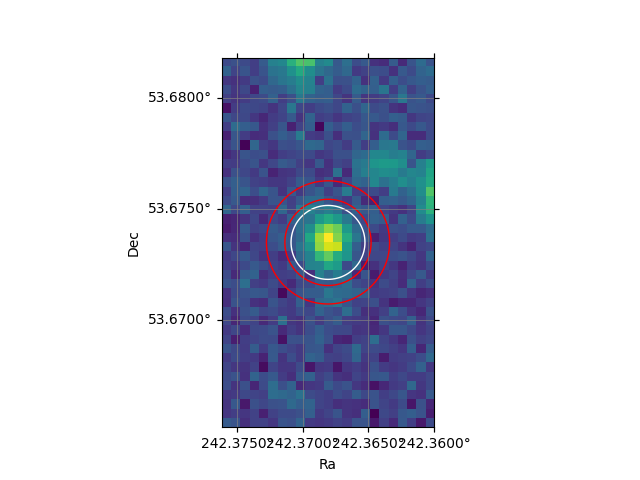

In [31]:
plot_map(transient, "counts", **{k: config_gaper[k] for k in ["ra", "dec", "radius", "annulus"]}, save=False)

In [16]:
mjd = 55370.57444444444 * 60*60*24
goff = 315964800
gmjd = mjd+goff
gmjd

5099982432.0

In [58]:
%%time
photon_events = run_gAperture(**config_gaper)

Using v1.28.9 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [242.368075, 53.673492]
 tranges: [[768413479.995, 768413580.995], [772224465.995, 772225688.995], [773123709.995, 773124202.995], [775283436.995, 775285077.995], [799089890.995, 799091497.995], [799225954.995, 799227043.995], [799291027.995, 799292207.995], [799296943.995, 799297509.995], [799308775.995, 799309669.995], [799415698.995, 799415804.995], [802267370.995, 802268489.995], [802332505.995, 802333573.995], [802374181.995, 802374993.995], [802450944.995, 802451924.995], [806060123.995, 806061578.995], [806071957.995, 806073409.995], [806083791.995, 806085240.995], [806108028.995, 806108899.995], [806409264.995, 806410592.995], [806509887.995, 806511165.995], [806527645.995, 806528914.995], [806616440.995, 806617663.995], [806628399.995, 806629496.995], [806634281.995, 806635413.995], [806693305.995, 806694584.995], [806699140.995, 806700501.995], [806758375.995, 806759678.

/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/MCUtils.py:54: RuntimeWarning: overflow encountered in square
  return np.sqrt((a-c)**2. + (b-d)**2.)


/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1000: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_1'] = (lcurve['mag'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1003: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_2'] = (gxt.counts2mag(lcurve['cps'] -


CPU times: user 6min 47s, sys: 25.3 s, total: 7min 12s                                                                  
Wall time: 1h 11min 6s


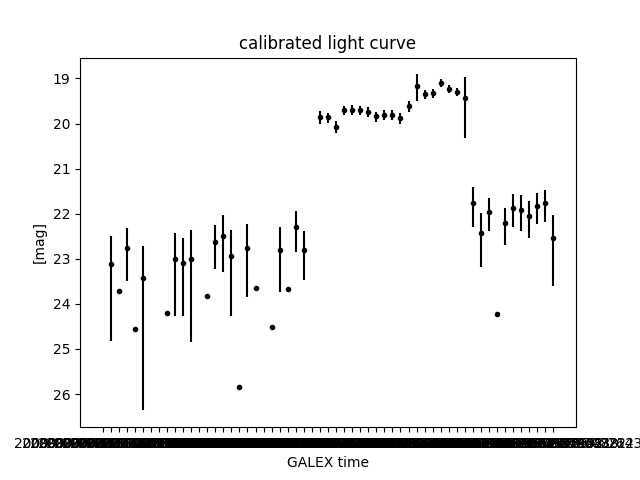

In [37]:
plot_lc(transient, trange=trange, xdates=True)

In [72]:
tgalex_to_astrotime(930498183, "iso")

'2009-07-01 15:43:03.000'

In [77]:
tgalex_to_astrotime(987452773, "iso")

'2011-04-21 20:26:13.000'

In [80]:
config_gaper_alt = {
    "transient":config_gfind["transient"],
    "band": config_gfind["band"],
    "ra":config_gfind["ra"],
    "dec":config_gfind["dec"],
    "stepsize": 100.0,
    "radius": (6 * u.arcsec).to(u.deg).value,
    "annulus": [
        (7 * u.arcsec).to(u.deg).value,
        (10 * u.arcsec).to(u.deg).value,
    ],
    "detsize": config_gfind["detsize"],
    "tranges": [[930498183.0, 987452774.0]],
    "maxgap": config_gfind["maxgap"],
    "verbose": 3,
    "overwrite": False,
}

In [81]:
%%time
photon_events = run_gAperture(**config_gaper_alt)

Using v1.28.9 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [242.368075, 53.673492]
 tranges: [[930498183.0, 987452774.0]]
 radius:  0.0016666666666666666
 annulus: [0.0019444444444444444, 0.002777777777777778]
 stepsz:  100.0
 csvfile: ./out/PS1-10jh_gAperture_lc.csv
 verbose: 3
CPU times: user 25.9 s, sys: 1.77 s, total: 27.7 s          42.368075, 53.673492]                                                            
Wall time: 5min 7s


['2004-05-12 16:12:00.763' '2004-05-12 16:12:40.592'
 '2004-06-25 18:48:01.435' ... '2011-06-10 16:27:46.388'
 '2011-06-10 16:28:47.234' '2011-06-10 16:29:34.550']


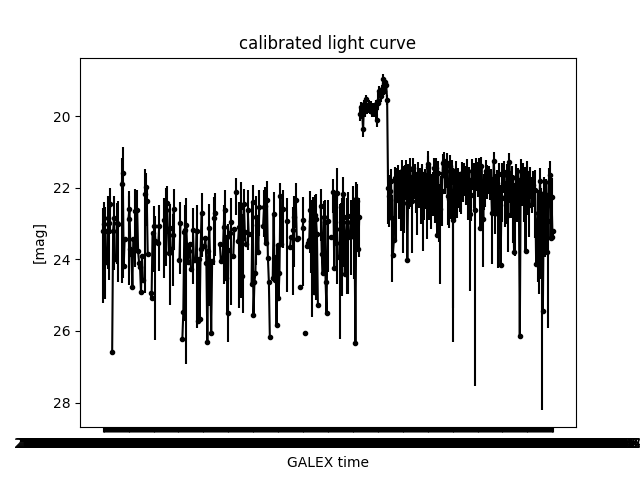

In [45]:
plot_lc(transient, trange=trange)

In [86]:
out_dir = "./out"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [34]:
lc_data = read_lc(config_gaper["csvfile"])
sel = photon_events["t_mean"] > 1

NameError: name 'read_lc' is not defined

TypeError: unhashable type: 'numpy.ndarray'

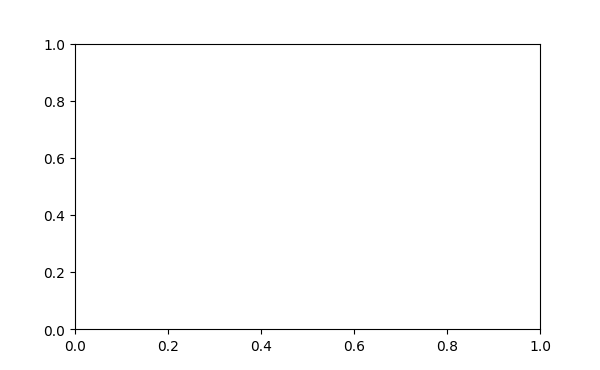

In [82]:
sel = photon_events["t_mean"] > 1
fig2, ax2 = vutils.nb_fig(num=f"{transient}_lc_alt", gr_size=6)
ax2.errorbar(
    photon_events[sel]["t_mean"],
    photon_events[sel]["mag_bgsub"],
    yerr=[photon_events[sel]["mag_bgsub_err_1"], photon_events[sel]["mag_bgsub_err_2"]],
    color="k",
    marker="o",
    ms=3,
)
ax2.set_title("calibrated light curve")
ax2.invert_yaxis()

In [87]:
[[tgalex_to_astrotime(t, "iso"), ts] for t, ts in zip(photon_events["t0"], photon_events["t1"])]

[['2009-07-01 15:43:03.000', 930498283.0],
 ['2009-07-01 15:44:43.000', 930498383.0],
 ['2009-07-01 15:46:23.000', 930498483.0],
 ['2009-07-01 15:48:03.000', 930498583.0],
 ['2009-07-01 15:49:43.000', 930498683.0],
 ['2009-07-01 15:51:23.000', 930498783.0],
 ['2009-07-01 15:53:03.000', 930498883.0],
 ['2009-07-01 15:54:43.000', 930498983.0],
 ['2009-07-01 15:56:23.000', 930499083.0],
 ['2009-07-01 15:58:03.000', 930499183.0],
 ['2009-07-01 15:59:43.000', 930499283.0],
 ['2009-07-01 16:01:23.000', 930499383.0],
 ['2010-05-03 18:29:43.000', 956946683.0],
 ['2010-05-03 18:31:23.000', 956946783.0],
 ['2010-05-03 18:33:03.000', 956946883.0],
 ['2010-05-03 18:34:43.000', 956946983.0],
 ['2010-05-03 18:36:23.000', 956947083.0],
 ['2010-05-03 18:38:03.000', 956947183.0],
 ['2010-05-03 18:39:43.000', 956947283.0],
 ['2010-05-03 18:41:23.000', 956947383.0],
 ['2010-05-03 18:43:03.000', 956947483.0],
 ['2010-05-03 18:44:43.000', 956947583.0],
 ['2010-05-03 18:46:23.000', 956947683.0],
 ['2010-05-

In [ ]:
[960828184, 964411383]